---
toc: true
layout: post
description: Experimenting with LLM temperature and its effects on answer quality
categories: [llm]
title: Experiments with Temperature
# image: 
author: Subhaditya Mukherjee
date : 2024-07-08
---

Over the past few months at OpenML, we have been experimenting with LLM models in an attempt to improve the search experience for our users. While our existing implementation uses ElasticSearch, we wanted to also have the option of having a more "semantic" search experience. 

Aside from the usual RAG pipeline that everyone and their grandparents seems to be using these days, we also wanted to experiment with using an LLM to semi-automatically generate filters for our search queries. While it may not seem like a big feature, it is something that has always been a bit of an annoyance for some of our users. 

So what does this entail? Consider the interface we have at the moment. We have a search bar at the top, and subsequently a bunch of filters that users can use to narrow down their search. While this works pretty well as is, how about trying to automate it a bit.

In summary, we want a query like "find me a large dataset with multiple classes of flowers" to automatically generate filters like "classification", "multiclass", "sort by size of dataset" etc.

![](search.png)

## Temperature

Think about the first time you used ChatGPT. What stood out to you? Was it how well it could elaborate on a topic? Or was it how creative it could be? The temperature parameter in LLMs is what controls this. 

How can we control creativity? Well, saying that we can directly control creativity is a bit of a stretch. We can however use a workaround.

Do you remember the softmax function? The function that takes a vector of arbitrary real-valued scores and squashes it into a vector of probabilities that sum to 1. The inputs to the softmax function are the unnormalized log likelikhoods or the raw per class score assigned by the model. 

The softmax function is defined as:
$$ \text{softmax}(x_i) = \frac{e^{x_i}}{\sum_{j=1}^{k} e^{x_j}} $$

If we want more control over the distribution of the probabilities, we can use a temperature parameter. This would look like:
$$ \text{softmax}(x_i) = \frac{e^{x_i/T}}{\sum_{j=1}^{k} e^{x_j/T}} $$
where $T$ is the temperature parameter.


- If $T = 1$, the softmax function is the same as the original softmax function.

- If $T > 1$, the probabilities will become "flatter". Since the difference between the probabilities will be less, the model can be more exploratory aka more creative.

- If $T < 1$, the distribution of the probabilities are "peakier". There will be a higher difference between the probabilities, leading to the model being more confident in its predictions, but also less creative.

### Visualizing Temperature using Softmax

In [28]:
from tqdm import tqdm
import regex as re
# LangChain supports many other chat models. Here, we're using Ollama
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from typing import List, Dict, Any
import numpy as np  
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd 
sns.set_theme(style="white")

In [29]:
def softmax(input, t=1.0):
  ex = np.exp(input/t)
  sum = np.sum(ex, axis=0)
  return ex / sum

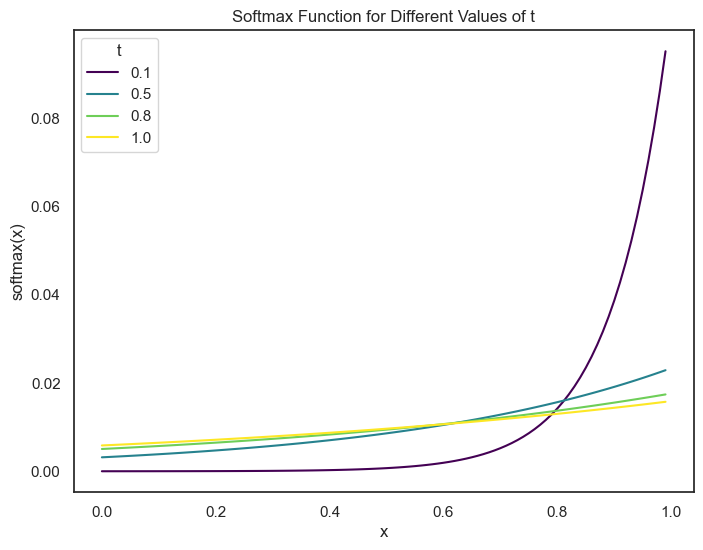

In [30]:
# plot softmax over a range of inputs
x = np.arange(0,1.0, 0.01)
t = np.array([0.1,.5, .8, 1.0])
y = np.array([softmax(x, ti) for ti in t])

# Create a DataFrame for Seaborn
data = pd.DataFrame({
    'x': np.tile(x, len(t)),
    'softmax': np.concatenate(y),
    't': np.repeat(t, len(x))
})

# Plotting with Seaborn
plt.figure(figsize=(8, 6))
sns.lineplot(data=data, x='x', y='softmax', hue='t', palette='viridis')
plt.xlabel('x')
plt.ylabel('softmax(x)')
plt.title('Softmax Function for Different Values of t')
plt.legend(title='t')
plt.show()

## Creating the Experimental Setup
Now, we can focus on testing the effects of temperature for our use case. We are using the `llama3` model for our experiments. The experiments are being run on a 2023 MacBook Pro with an M3 chip and 18GB memory.

### Defining a Prompt
We need to first think of a prompt that we can use for our experiments. This prompt can be thought of as an instruction that the model uses along with the query to generate answers. To make it easier for us to use, we only want one/two word answers and for now we are only focusing on a small subset of the filters that we want our model to understand.

In [32]:
prompt = """User Query : {query}
Based on the query, answer the following questions one by one in one or two words only and a maximum of two with commas only if asked for. Use only the information given and do not make up answers - 
Does the user care about the size of the dataset? Yes/No and if yes, ascending/descending.
Does the user want to sort by number of downloads? Yes/No.
Does the user care about missing values? Yes/No.
If it seems like the user wants a classification dataset, is it binary/multi-class/multi-label? If not, say none.
"""

In [33]:
query = "Find me a big classification dataset about mushrooms"

### Creating a Chain
Since we are using the `langchain` and `ollama` libraries for our experiments, we follow their API and create a chain. The template uses string formatting to insert the prompt and the query into the chain.

In [34]:
def create_chain(prompt , temperature, llm_model = "llama3"):
    prompt = ChatPromptTemplate.from_template(prompt)
    llm = ChatOllama(model=llm_model, temperature=temperature)
    chain = prompt | llm | StrOutputParser()
    return chain

### Parsing the Results
To make it easier for us to analyze the results, we generate an example answer and then see see if any further processing is needed.

In [35]:
# functiont to parse responses like this to a list of yes/no/none/yes,aescending/no etc
def parse_response(response):
    # split by new line and remove first two lines (here are the answers:)
    response = response.split('\n')[2::]
    # if response has a question mark, split by question mark and remove empty strings
    for i in range(len(response)):
        if '?' in response[i]:
            response[i] = response[i].split('?')[1].strip()
    # replace full stops with empty strings
    response = [x.replace('.','') for x in response]
    response = [x for x in response if x]
    return response

In [8]:
chain = create_chain(prompt, 0.5)
response = chain.invoke({"query": query})
print(response)

Here are the answers:

1. Does the user care about the size of the dataset?
Yes, ascending.

2. Does the user want to sort by number of downloads?
No

3. Does the user care about missing values?
No

4. Is it a classification dataset? If so, is it binary/multi-class/multi-label?
Yes, multi-class


Yay, it works. We now write a function to generate results for different temperatures.

In [9]:
def generate_results_for_temp(query:str, range_of_temps : np.ndarray) -> List[List[str]]:
    results = []
    for temperature in tqdm(range_of_temps):
        chain = create_chain(prompt, temperature)
        response = chain.invoke({"query": query})
        results.append(parse_response(response))
    return results
        

## Running the Experiments and Plotting Results
It is time to run the experiments and plot the results. 
We write a function to plot the results in a `stripplot` to see the distribution of the answers for different temperatures.

In [50]:
def plot_yes_no(df: pd.DataFrame, title:str) -> None:
    fig, axs = plt.subplots(2, 2, figsize=(15, 15))
    fig.suptitle(title)
    sns.stripplot(data=df, x='size', y='temperature', ax=axs[0, 0], hue='size')
    sns.stripplot(data=df, x='sort_by_downloads', y='temperature', ax=axs[0, 1], hue='sort_by_downloads')
    sns.stripplot(data=df, x='missing_values', y='temperature', ax=axs[1, 0], hue='missing_values')
    sns.stripplot(data=df, x='classification_type', y='temperature', ax=axs[1, 1], hue='classification_type')
    # tilt x axis labels
    for ax in axs.flat:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
    plt.show()

Sometimes, the model returns an extra field, we combine the last two fields to plot the results. (This is a bit of a hack, but it works for now and is ONLY used for plotting)

In [86]:
def combine_last_two_elements(lst):
    # Check if the list has at least two elements
    if len(lst) > 4:
        # Combine the last two elements with a space separator
        combined_element = lst[-2] + ' ' + lst[-1]

        # Create a new list with combined element instead of the last two
        return lst[:-2] + [combined_element]
    else:
        return lst

### Experiment 1
Out first experiment is a rather simple query, "Find me a big classification dataset about mushrooms". As you can probably guess, we are looking for a dataset that is large, is a classification dataset and is about mushrooms.

In [37]:
range_of_temps = np.linspace(0, 1, 20)
query = "Find me a big classification dataset about mushrooms"
results1 = generate_results_for_temp(query, range_of_temps)

100%|██████████| 20/20 [00:49<00:00,  2.49s/it]


In [38]:
results1 = [[y for y in x if all(sub not in y for sub in ["If", ":"])] for x in results1]

/var/folders/_f/ng_zp8zj2dgf828sb6s5wdb00000gn/T/ipykernel_42184/3521201435.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
/var/folders/_f/ng_zp8zj2dgf828sb6s5wdb00000gn/T/ipykernel_42184/3521201435.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
/var/folders/_f/ng_zp8zj2dgf828sb6s5wdb00000gn/T/ipykernel_42184/3521201435.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
/var/folders/_f/ng_zp8zj2dgf828sb6s5wdb00000gn/T/ipykernel_42184/3521201435.py:10: UserWarning: set_ticklabels()

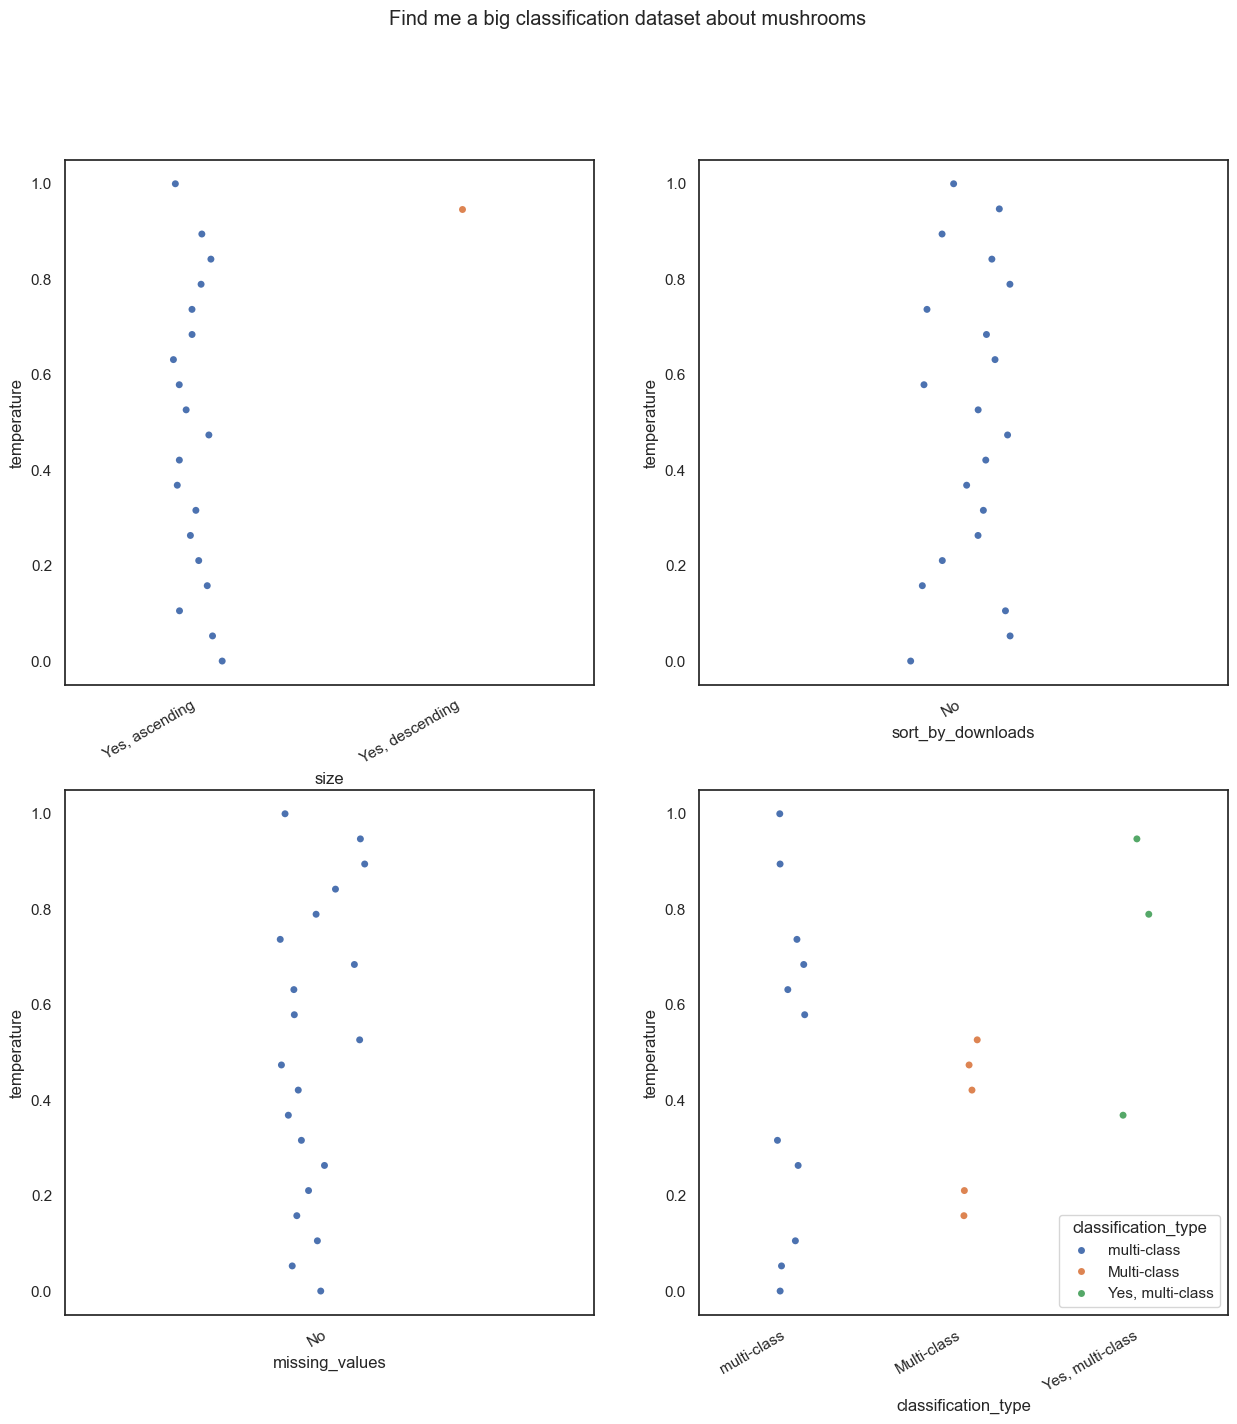

In [51]:
df = pd.DataFrame(results1, columns = ['size', 'sort_by_downloads', 'missing_values', 'classification_type'])
df['temperature'] = range_of_temps
plot_yes_no(df, title = query)

Rather interesting don't you think? At higher temperatures, the model gets the answers wrong. Even at a temperature slightly above 0.1, the model starts adding extra information to it's answers.

Did you notice that I tried to remove sentences that started with "If"? There are more examples of this later, but this is because at higher temperatures, the model tends to add random sentences to the answers and this makes it quite hard to plot them.

### Experiment 2
Our second experiment is super easy. "Find me a dataset that has a lot of missing values and order by number of downloads". As you can obviously guess, we are looking for a dataset that has a lot of missing values and we want to order the results by the number of downloads.

In [52]:
range_of_temps = np.linspace(0, 1, 20)
query = "Find me a dataset that has a lot of missing values and order by number of downloads"
results2 = generate_results_for_temp(query, range_of_temps)
results2 = [[y for y in x if "so" not in y] for x in results2]


100%|██████████| 20/20 [00:34<00:00,  1.74s/it]


/var/folders/_f/ng_zp8zj2dgf828sb6s5wdb00000gn/T/ipykernel_42184/3521201435.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
/var/folders/_f/ng_zp8zj2dgf828sb6s5wdb00000gn/T/ipykernel_42184/3521201435.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
/var/folders/_f/ng_zp8zj2dgf828sb6s5wdb00000gn/T/ipykernel_42184/3521201435.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
/var/folders/_f/ng_zp8zj2dgf828sb6s5wdb00000gn/T/ipykernel_42184/3521201435.py:10: UserWarning: set_ticklabels()

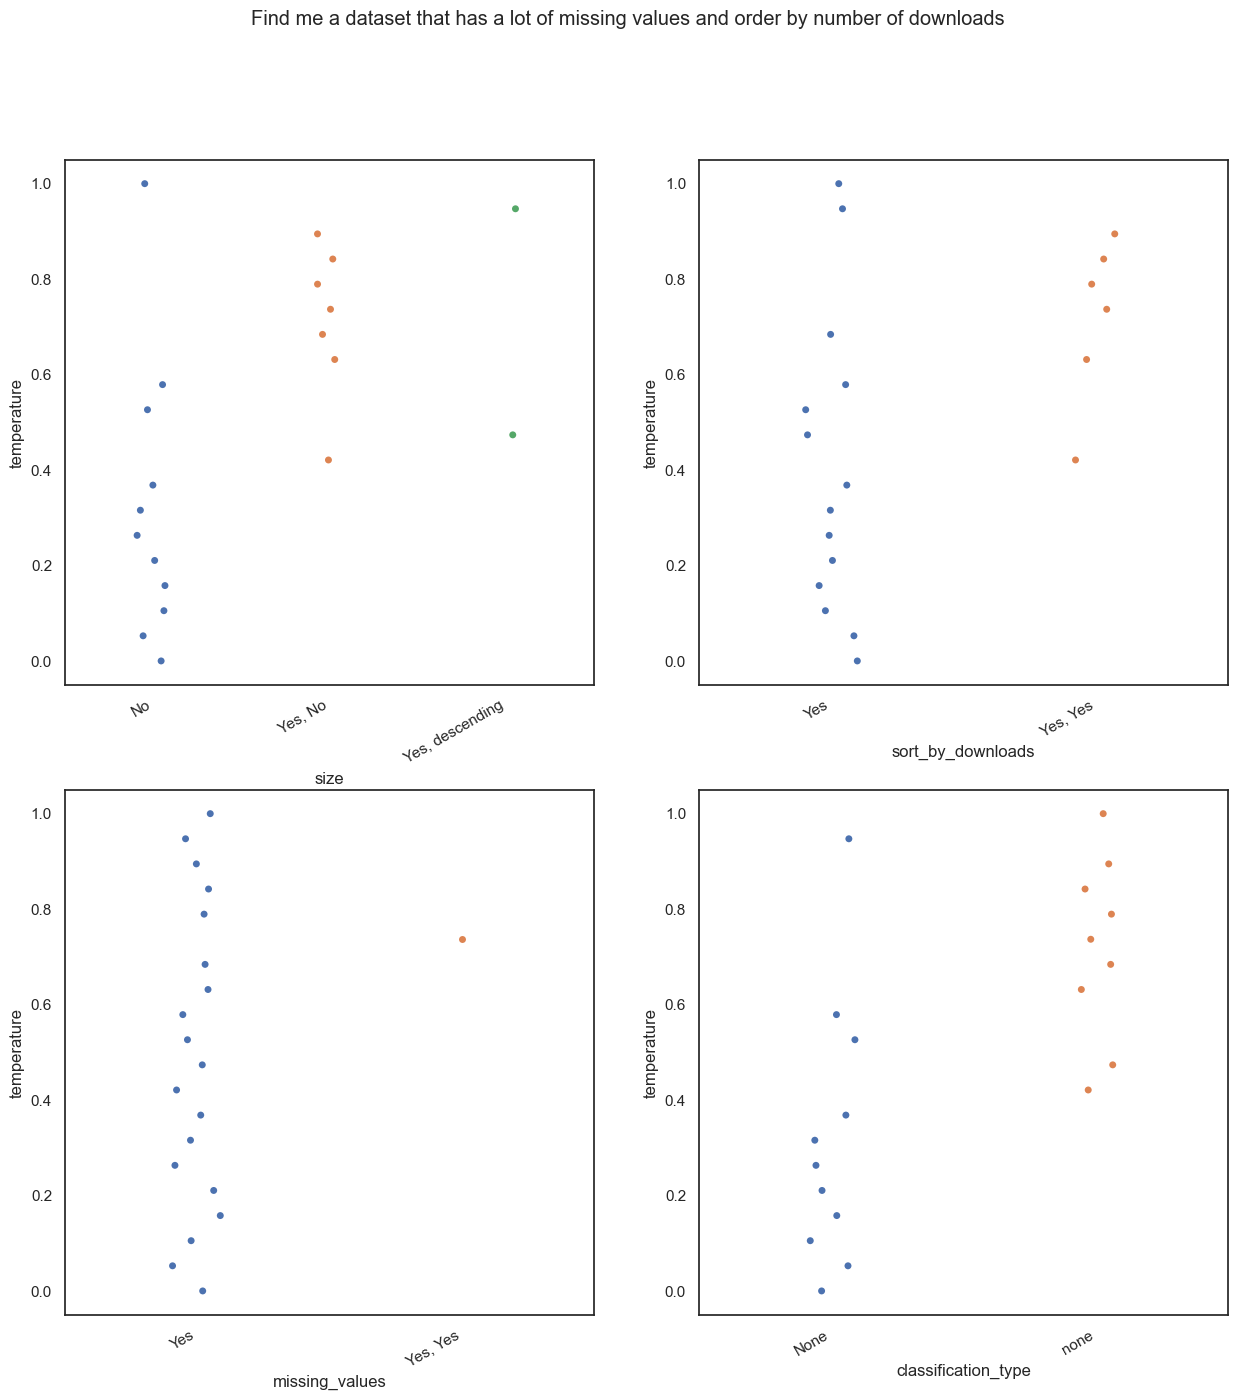

In [53]:
df = pd.DataFrame(results2, columns = ['size', 'sort_by_downloads', 'missing_values', 'classification_type'])
df['temperature'] = range_of_temps
plot_yes_no(df, title = query)

Hmm, same as before. The model starts adding extra information at higher temperatures and starts getting the answers wrong. (Yes, No?? ) What kind of answer is that?

## Experiment 3
- Now a slightly more complex query. "Find me a dataset that has 10 classes and sort by number of downloads". We want it to understand that we want a multiclass classification dataset and we want to sort the results by the number of downloads.

In [55]:
range_of_temps = np.linspace(0, 1, 20)
query = "Find me a dataset that has 10 classes and sort by number of downloads"
results3 = generate_results_for_temp(query, range_of_temps)

100%|██████████| 20/20 [00:55<00:00,  2.80s/it]


In [87]:
results3 = [combine_last_two_elements(x) for x in results3]

/var/folders/_f/ng_zp8zj2dgf828sb6s5wdb00000gn/T/ipykernel_42184/3521201435.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
/var/folders/_f/ng_zp8zj2dgf828sb6s5wdb00000gn/T/ipykernel_42184/3521201435.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
/var/folders/_f/ng_zp8zj2dgf828sb6s5wdb00000gn/T/ipykernel_42184/3521201435.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
/var/folders/_f/ng_zp8zj2dgf828sb6s5wdb00000gn/T/ipykernel_42184/3521201435.py:10: UserWarning: set_ticklabels()

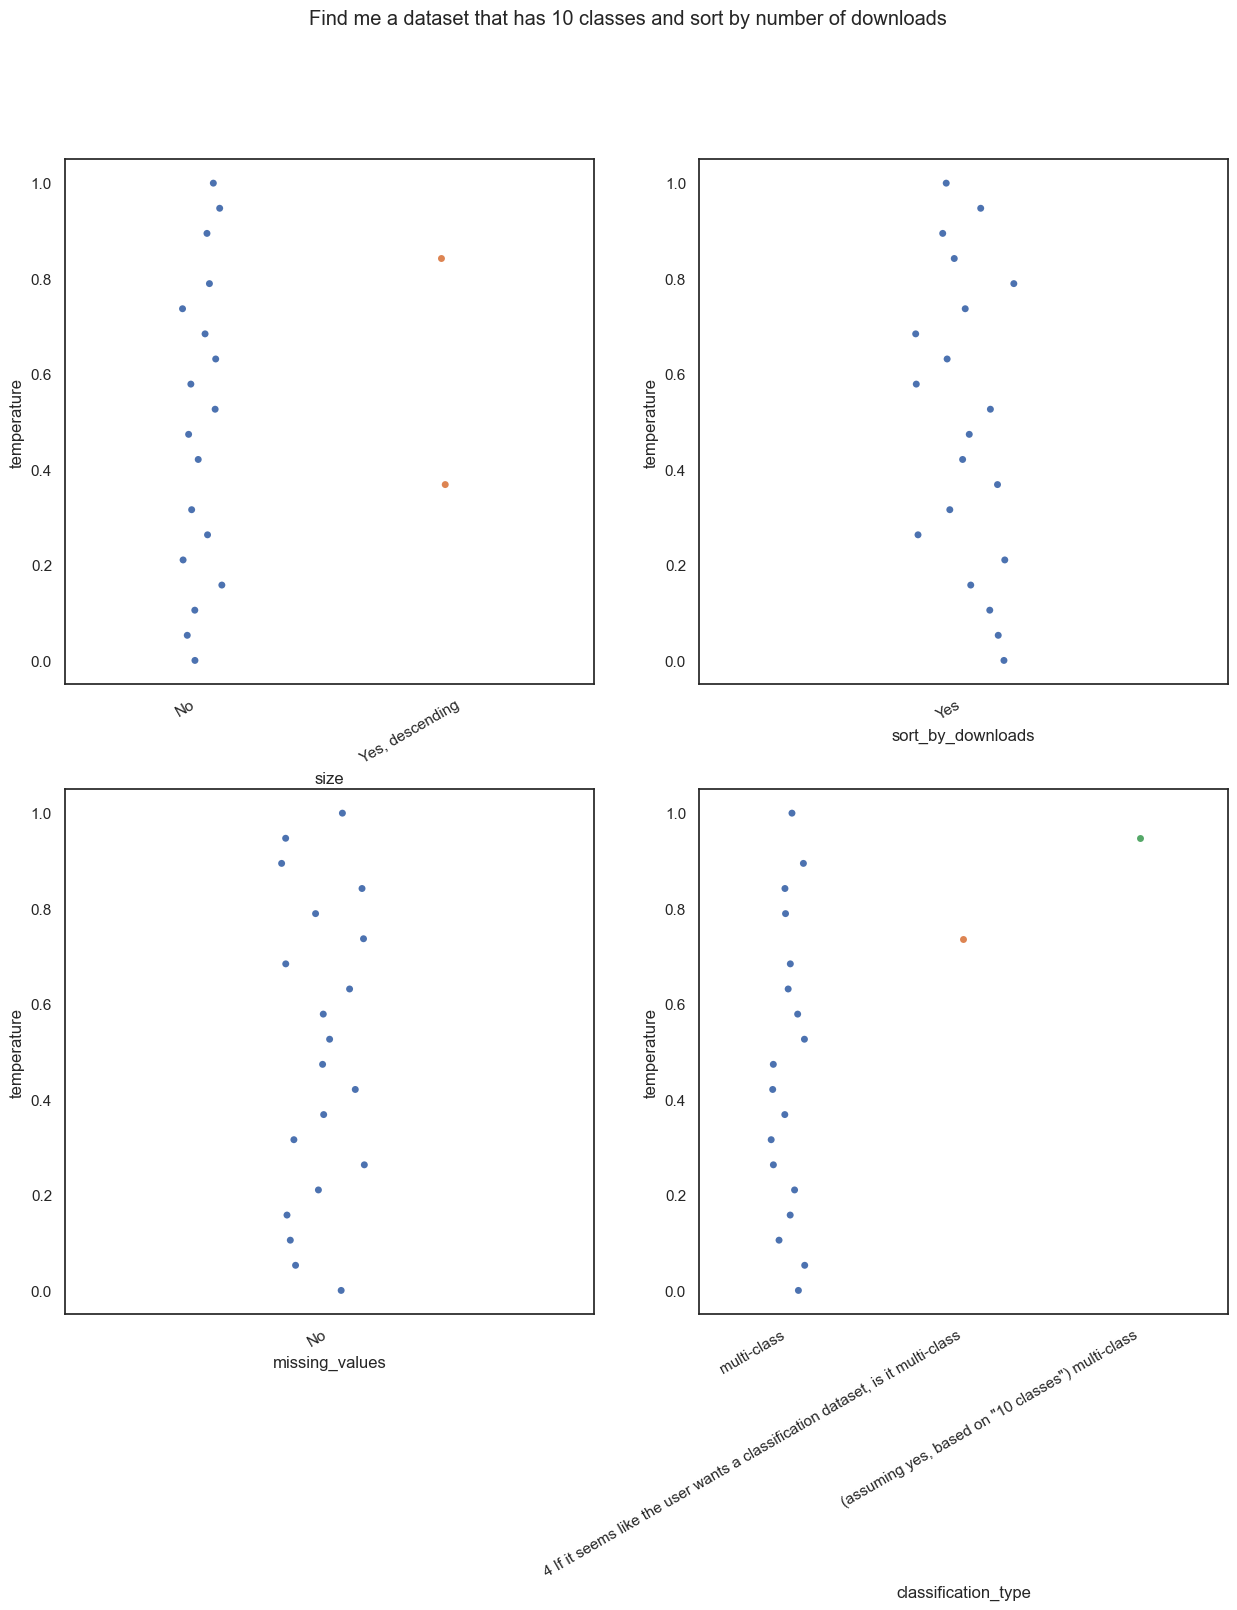

In [88]:
df = pd.DataFrame(results3, columns = ['size', 'sort_by_downloads', 'missing_values', 'classification_type'])
df['temperature'] = range_of_temps
plot_yes_no(df, title = query)

This seems to have been very easy for the model. But as always, the model starts adding extra information at higher temperatures. A lot of extra information in fact. Even though the prompt says to ONLY answer with one or two words

## Experiment 4
- "Find me a dataset that 2 classes and is a big dataset". You know the drill by now. We want a binary classification dataset that is large.

In [95]:
range_of_temps = np.linspace(0, 1, 20)
query = "Find me a dataset that 2 classes and is a big dataset"
results4 = generate_results_for_temp(query, range_of_temps)

100%|██████████| 20/20 [00:42<00:00,  2.14s/it]


In [96]:
results4 = [combine_last_two_elements(x) for x in results4]

/var/folders/_f/ng_zp8zj2dgf828sb6s5wdb00000gn/T/ipykernel_42184/3521201435.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
/var/folders/_f/ng_zp8zj2dgf828sb6s5wdb00000gn/T/ipykernel_42184/3521201435.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
/var/folders/_f/ng_zp8zj2dgf828sb6s5wdb00000gn/T/ipykernel_42184/3521201435.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
/var/folders/_f/ng_zp8zj2dgf828sb6s5wdb00000gn/T/ipykernel_42184/3521201435.py:10: UserWarning: set_ticklabels()

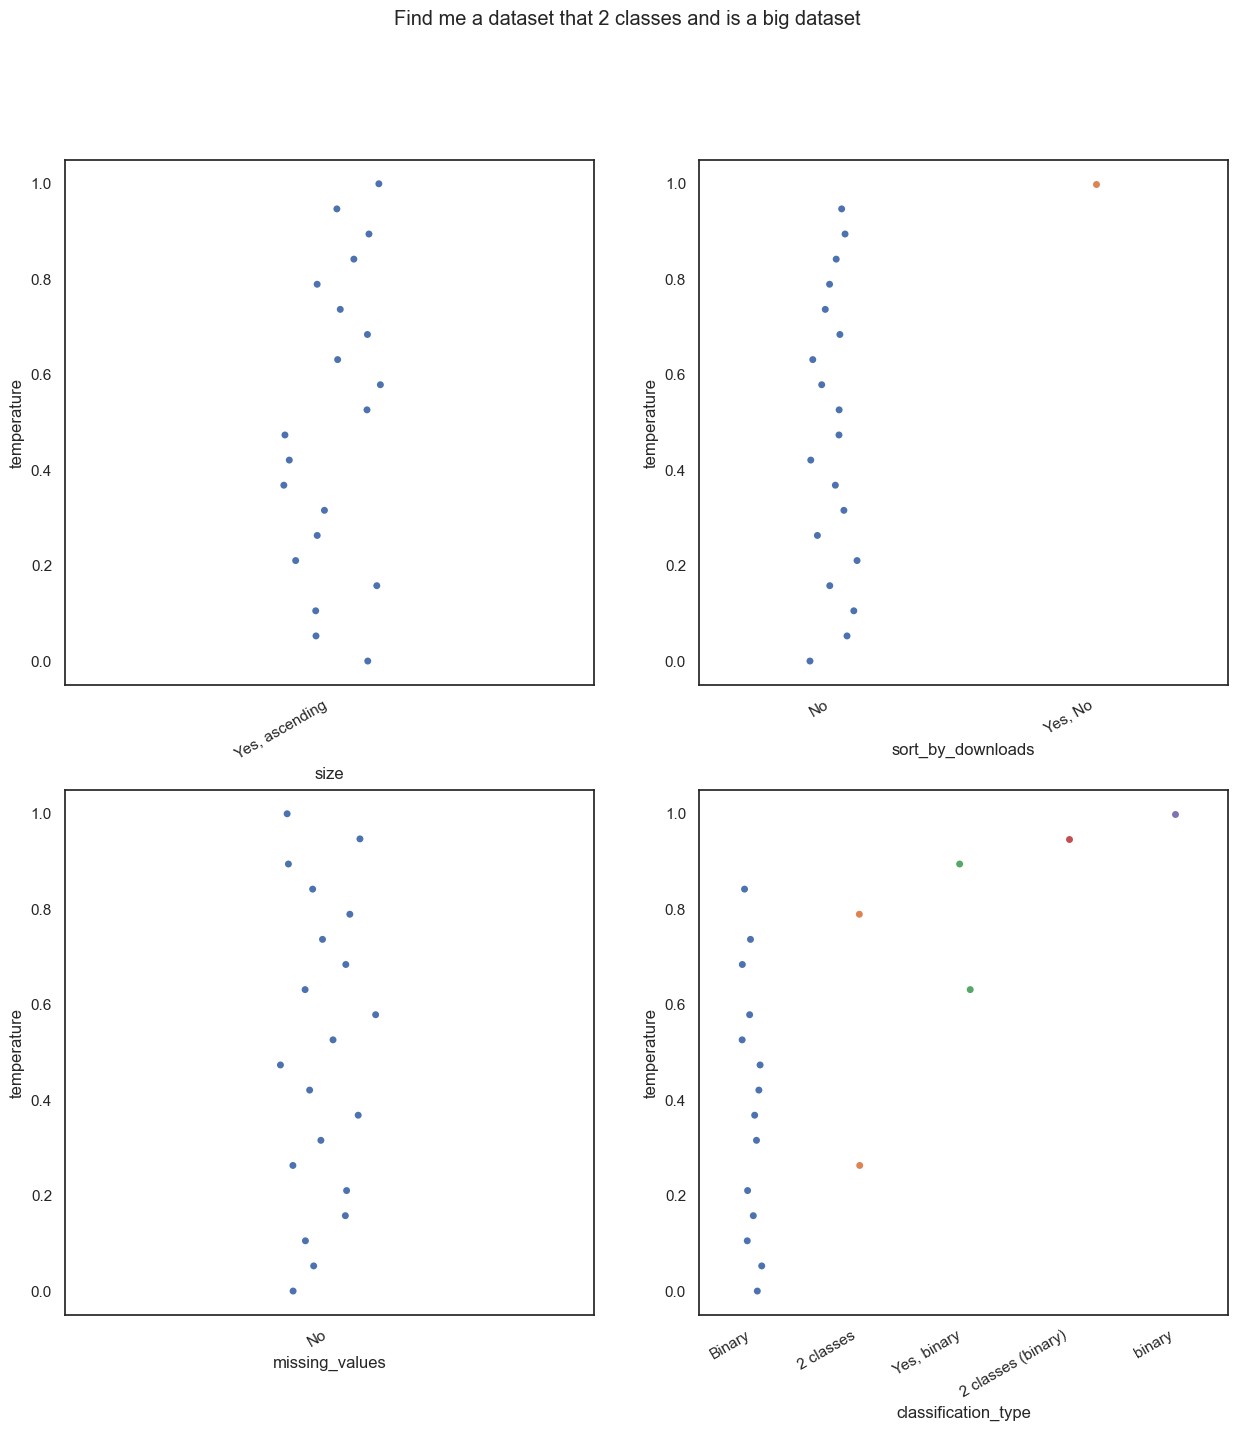

In [97]:
df = pd.DataFrame(results4, columns = ['size', 'sort_by_downloads', 'missing_values', 'classification_type'])
df['temperature'] = range_of_temps
plot_yes_no(df, title = query)

Notice how some things changed? At higher temperatures, we get extended answers.

## Conclusion

In conclusion, we can see that we should probably stick to lower temperatures for our use case. As we go higher, the model starts being more "creative" and either adds extra information to the answers or gets them wrong. While this behaviour might be useful in cases like creative writing, it is not something we want in our search.

Using LLMs can sometimes be a bit of a hit or miss. But of course, learning to control it's parameters can help us get the most out of it. This blog post was just a simple experiment, but in the deluge of content made by people who have no idea what Softmax is, I hope this was helpful.